# Using Autopew
In this notebook we will go through some examples of ways in which autopew can help with automated target selection

autopew is an open access python package designed for coordinate system translation which enables easy referencing between analytical equipment and/or images. This allows the valuable time on analytical equipment to be more effectively used for data collection rather than on locating the areas of interest.

## The basics

For the transform we are using the Pew module in autopew. It breaks down to 3 sets of numbers: 

[source_reference_points], 
[destination_reference_points], and 
[sample_points].

These can be .csv files, an array or even picked using the autopew gui. 

The input data files contain columns 'x', 'y' and 'name' but can contain additional columns.

The reference points are used to create the affine transform. These files can contain as many reference points as you like through we suggest 3 ore more to create an accurate transform. This transform is applied to our samples and exported to a native file type for the analytical equipment carrying consistent names and allows for a z value to be defined for each export.

More export file types can be easily created so please feel free to contribute. <https://autopew.readthedocs.io/en/develop/dev/development.html> 

The three examples below have the transformed visualised. The visualisation is optional however is useful to determine if the transformation are sensible. 


# Stage to Stage
It is common to measure the same location between multiple analytical techniques. For example, laser ablation analysis (LA-ICP-MS) typically requires the major elements to be analysed using electron microprobe (EPMA). Using autopew, the translation between these two stage coordinate systems is simplified. The new coordinates carry consistent point names between the techniques and simplifies the process of merging the major element and trace element datasets. It also allows hundreds of named points to be imported into the analytical equipment with time only spent locating 4 analysis points.


### Aim of this example
In this example we wanted to import more than 100 points that had been previously analysed with LA-ICP-MS for analysis by EPMA. We needed consistent naming to ensure the data merging was simple in the future.

We will be converting a csv with x,y coordinates and point labels to a .pos file for import into the EPMA and .scancsv for import into the LA-ICP-MS.

We first load in our files which contain the sample points, the reference points in the source coordinate system (laser) and the same 4 reference points in the destination coordinate system (EPMA). The new (transformed) sample coordinates carry the names over from the source.

In [21]:
%matplotlib inline
from autopew import Pew
from autopew.util.plot import plot_transform

# %% LOAD reference points and sample points ---------------------------------------------------------------
points = (Pew("Supplementary Material/Reference Points_source.csv",
              "Supplementary Material/Reference Points_dest.csv")
              .load_samples('Supplementary Material/Sample_points.csv'))

#lets look at our transformed samples
points.transformed

,name,x,y
0,pn26,294.204013,2078.575222
1,pn27,302.030315,2085.294043
2,po60,348.921976,2131.215520
3,ccp43,735.192648,3680.307512
4,ccp44,746.241125,3582.193837
...,...,...,...
99,ccp32,3973.599460,3779.774521
100,pn14,3966.061682,3722.010381
101,po30,3966.565304,3602.726936
102,po29,3983.256383,3550.270326


Just to check we haven't got the reference points mixed up, lets visualise the transform.

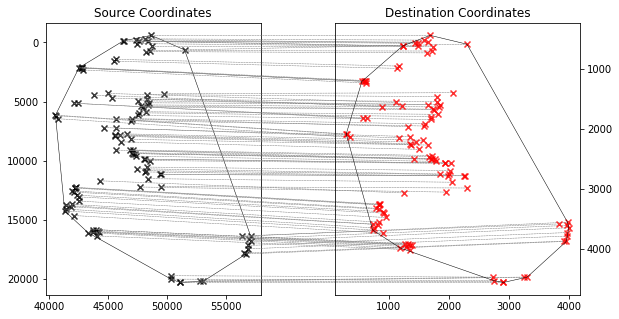

In [22]:
# %% VISUALISE THE TRANSFORM ---------------------------------------------------------------
fig = plot_transform(
    points.samples[['x', 'y']].values,
    points.transformed[['x', 'y']].values)

Looks great! 

Lets export to all our file types! We also defined the z distance for the samples in both the EPMA (.pos) and laser (.scancsv).

In [23]:
# %% EXPORT -----------------------------------------------------------
points.export_samples("Points_new.pos", z=10.7)
points.export_samples("Points_new.scancsv", z=20744)
points.export_samples("Points_new.csv")

# Stage to Image
autopew enables the context of each in-situ microanalysis to be recorded by referencing to large images. This will give new insights into what effects the chemistry of given particles with reference to their location and microenvironment and allows for inferences on macroscale processes from well characterised in-situ microanalysis. Also this process allows for archiving of
the micro-geo-referencing for all analysis for future users of the data.

#### Aim of this example

In the following example we were wanting to label each of the previously collect laser analysis with the analysis name to ensure to give context to the analysis of the sulfide with respect to its position in the sample.   

We will be using a .csv which is a list of coordinates and labels and converting it to pixel coordinates. We define the reference points on the image as an array of pixels paired to the array from the laser coordinates.


In [24]:
from autopew import Pew
import numpy as np
from autopew.workflow import pick_points

# %% REFERENCE POINTS ------------------------------------------------------------
#these are the known locations of the reference points in the laser coordinate system
laser_reference_coords =np.array([[45633,9098],  #R1-ccp55
                                  [56683,17876], #R2-ccp33
                                  [43301,16082], #R3-ccp38
                                  [42096,5137]]) #R4-pn25

#pick the reference points on the image
img_reference_coords =np.array([[ 736.90221101,1293.38784469],#R1-ccp55
                                [2097.00269965,2020.88345489],#R2-ccp33
                                [ 624.43912151,2080.62947119],#R3-ccp38
                                [ 290.56432456,927.88280382]])#R4-pn25

# %% TRANSFORM laser to pixels ---------------------------------------------------------------
points = Pew(laser_reference_coords, img_reference_coords).load_samples('Supplementary Material/Sample_points.csv')

### plotting pixel points on the image
Now that we have transformed our laser analysis to pixel coordinates, we can plot them on top of a collected image. In this case a secondary electron image from the SEM. You should be able to see the laser ablation pit inside each marker!

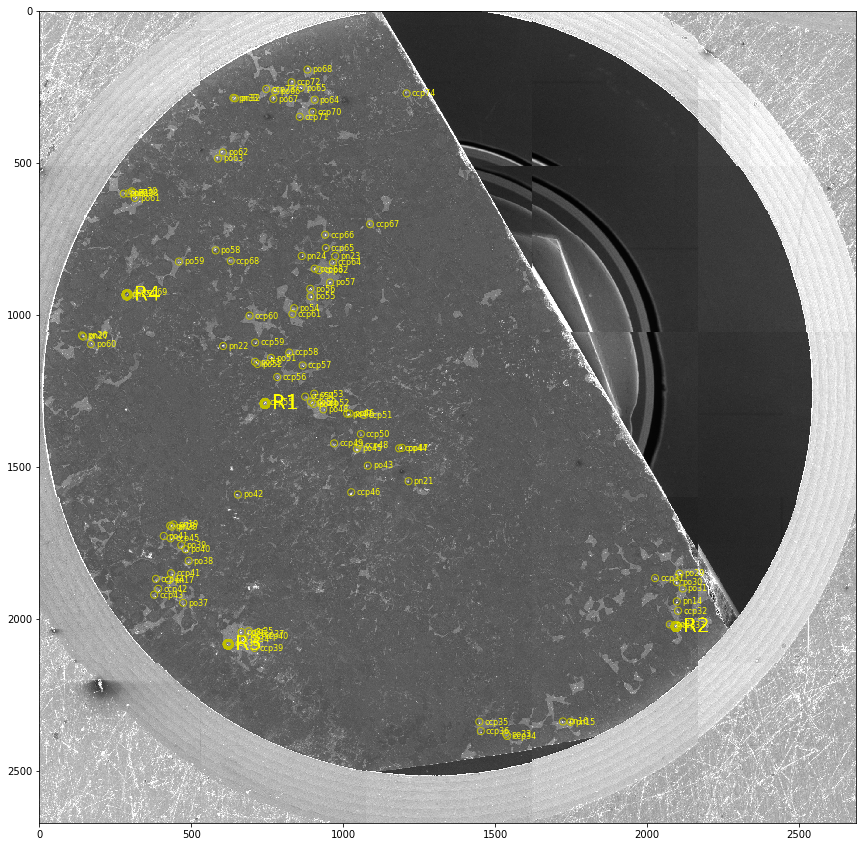

In [25]:
import matplotlib.pyplot as plt
from PIL import Image

# %% PLOT ON IMAGE ---------------------------------------------------------------

# FIND THE PIXEL SIZE OF THE IMAGE
img = Image.open("Supplementary Material/SEM_RefPoints.png")
width, height = img.size # get the image's width and height in pixels

#markers
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(points.transformed['x'], 
           points.transformed['y'],
           facecolors='none', 
           edgecolors='y', 
           marker="o",
           s=50,
           linewidth=1,
           zorder=1)
#labels
for i, df in enumerate(points.transformed['name']):
    ax.annotate(df, 
                (points.transformed.x[i], points.transformed.y[i]),
                xytext=(5, 0), 
                textcoords='offset points',
                horizontalalignment='left', 
                verticalalignment='center',
                size=8, 
                color='yellow',
                zorder=1
               )
ax.set(xlim=(0, width), ylim=(0, height))
plt.imshow(img, zorder=0)
ax.invert_yaxis()#image invert so it is the same up direction as import.
plt.tight_layout()
plt.show()

# %% SAVE IMAGE ---------------------------------------------------------------
#fig.savefig('Export_image.png', transparent=True, dpi=300)

# Image to Stage


Time can be very expensive on analytical equipment. The less time the equipment is spent idle, the more value you can achieve from your analysis day. Pre-picking microanalysis regions using large images from optical microscopes or from XRF mapping techniques allows for a significant increase in the amount of data collected as well as more thought given to the context of
each analysis.

autopew can easily translate between pixel coordinates into stage coordinates.

#### This example heavily uses the autopew GUI which is not compatible with Binder.  You can try this example with the GUI on your local computer or, in Binder a .gif example will load to display the GUI example.


##### to use the GUI
To use the GUI to select points

zoom = mouse wheel (scroll)

navigate = right mouse - click and drag

place point = left mouse click

save and exit = close window button

#### Aim of this example

In the following example we were targetting chromite (bright red in X-ray Fluorescence image) for analysis by LA-ICP-MS.   

First we will load the X-ray Fluorescence (XRF) image and pick as many chromite as you see fit using the autopew GUI.

In [6]:
import numpy as np
from pathlib import Path
from autopew import Pew
from autopew.workflow import pick_points
from util import backup_pick_samples, backup_pick_calibration_points

# %% PICK THE ANALYSIS POINTS FROM AN IMAGE ------------------------------------------------------------
# have an image you wish to use?
imagepath = "Supplementary Material/XRF_Cr.Fe.Ca_chromite_Ref_coords.jpg"

# pick sample coordinates from the image

try:
    sample_points = pick_points(imagepath)
except:
    sample_points = backup_pick_samples(imagepath)

Now that we have our target points we need to register the image to the stage coordinates. 

We'll find parts of the image we can easily identify in both the analytical equipment and the image. Write down the coordinates for these 4 (or more) points then tell autopew where they are in the image. Also take note of the focus (z) for the sample.

I already marked 4 points on the image that I was able to easily recognise in the laser chamber, use these as the reference marks.


In [7]:
# %% REFERENCE POINTS ------------------------------------------------------------
#these are the known locations of the reference points on the laser stage
laser_REF_coords = np.array([
      [19700,-13833], #R1
      [48000,-26566], #R2
      [43033,-16566], #R3
      [50200,-4333]]) #R4

# pick reference coordinates from the image

try:
    pixel_REF_points = pick_points(imagepath)
except:
    pixel_REF_points = backup_pick_calibration_points(imagepath)

print(pixel_REF_points)#print the pixel reference points for your records

[[ 790.56182796  551.68240367]
 [1921.40860215 1061.35982303]
 [1719.66129032  661.4046259 ]
 [2006.35483871  171.19405242]]


Now we have the reference points, we can transform the sample coordinates, visualise the transform to ensure we didn't get the reference coordinates mixed up and then export as a .scancsv file. 

In the export we also define the z distance and any prefix for the spotnames for analysis on the LA-ICP-MS.

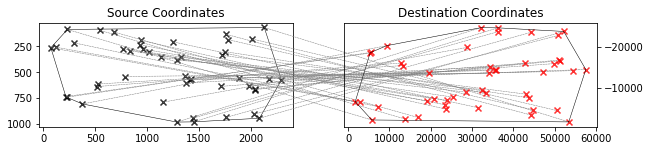

In [8]:
# %% TRANSFORM ---------------------------------------------------------------
points = (Pew(pixel_REF_points,
              laser_REF_coords)
              .load_samples(sample_points))

# %% VISUALISE ------------------------------------------------------------
from autopew.util.plot import plot_transform
fig = plot_transform(
    points.samples[['x', 'y']].values,
    points.transformed[['x', 'y']].values)

# %% EXPORT -----------------------------------------------------------
points.export_samples("Points_new.scancsv", z=20744, spotnames="chromite")

Since we spent all that time picking those points, lets export an image with the points on it for our records

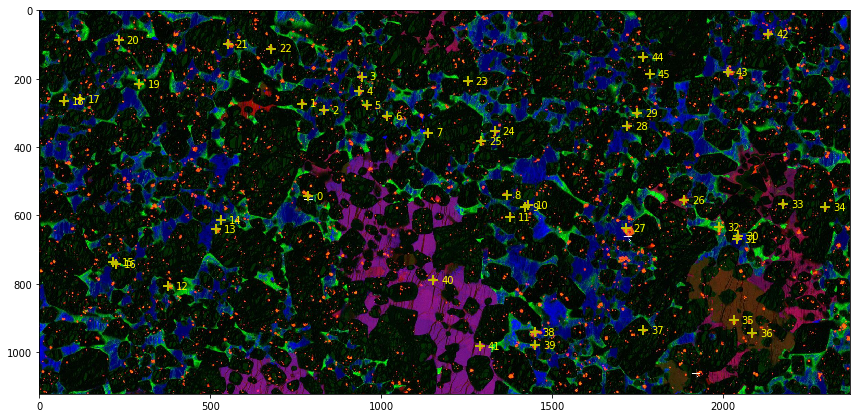

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

# %% PLOT ON IMAGE ---------------------------------------------------------------

# FIND THE PIXEL SIZE OF THE IMAGE
img = Image.open(imagepath)
width, height = img.size # get the image's width and height in pixels

#this time we want to plot points.samples rather than points.transformed because our source coordinates are the pixels

#markers
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(points.samples['x'], 
           points.samples['y'],
           facecolors='y', 
           edgecolors='y', 
           marker="+",
           s=100,
           linewidth=2,
           zorder=1)
#labels
for i, df in enumerate(points.samples['name']):
    ax.annotate(df, 
                (points.samples.x[i], points.samples.y[i]),
                xytext=(8, 0), 
                textcoords='offset points',
                horizontalalignment='left', 
                verticalalignment='center',
                size=10, 
                color='yellow',
                zorder=1
               )
ax.set(xlim=(0, width), ylim=(0, height))
plt.imshow(img, zorder=0)
ax.invert_yaxis()#image invert so it is the same up direction as import.
plt.tight_layout()
plt.show()

# %% SAVE IMAGE ---------------------------------------------------------------
#fig.savefig('Export_image.png', transparent=True, dpi=300)